# Creating Dataframe

In [76]:
import pandas as pd
import numpy as np

In [77]:
humidity_df = pd.read_csv("dataset/humidity.csv")
temperature_df = pd.read_csv("dataset/temperature.csv")
wind_speed_df = pd.read_csv("dataset/wind_speed.csv")

In [78]:
cities = ["Vancouver", "Chicago", "Miami"]

In [79]:
def get_city():
    for city in cities:
        yield city

In [80]:
for city in get_city():
    print(city)

Vancouver
Chicago
Miami


In [81]:
def get_dataset(city_name):
    df = pd.concat([temperature_df["datetime"], temperature_df[city_name], humidity_df[city_name], wind_speed_df[city_name]], axis=1)
    df.columns = ["datetime", "temp", "humid", "wind_sp"]
    df = df.iloc[1:]
    df = df.ffill()
    df["temp"] = (df["temp"] - 273.15) * 1.8 + 32
    return df

In [82]:
df = get_dataset("Vancouver")
df.isna().sum()

datetime    0
temp        0
humid       0
wind_sp     0
dtype: int64

In [83]:
df.shape

(45252, 4)

In [84]:
df.head()

,datetime,temp,humid,wind_sp
1,2012-10-01 13:00:00,52.664000,76.0,0.0
2,2012-10-01 14:00:00,52.662274,76.0,0.0
3,2012-10-01 15:00:00,52.658596,76.0,0.0
4,2012-10-01 16:00:00,52.654918,77.0,0.0
5,2012-10-01 17:00:00,52.651240,78.0,0.0


In [85]:
df.describe()

,temp,humid,wind_sp
count,45252.000000,45252.000000,45252.000000
mean,51.413027,81.942500,2.460223
std,11.887449,14.480778,1.997609
min,-18.400000,12.000000,0.000000
25%,42.962000,73.000000,1.000000
50%,50.882000,86.000000,2.000000
75%,59.648000,93.000000,4.000000
max,92.930000,100.000000,25.000000


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45252 entries, 1 to 45252
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  45252 non-null  object 
 1   temp      45252 non-null  float64
 2   humid     45252 non-null  float64
 3   wind_sp   45252 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.4+ MB


# Setting up the Env

### Environment

In [87]:
# %pip install gymnasium stable-baselines3 

In [99]:
import gymnasium as gym  
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env  

class SensorBasedThermalEnv(gym.Env):
    """
    Updated HVAC environment:
    - All temperatures in Fahrenheit
    - T_in between 65°F and 75°F
    - Simulated sensor-like indoor temp readings
    """
    def __init__(self, df):
        super(SensorBasedThermalEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.max_time_index = len(self.df) - 9  # 8 steps ahead needed for future

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation: [T_in, T_out, T_out_future, Humid, Wind_sp, Time_step]
        low_obs = np.array([60.0, -10.0, -10.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high_obs = np.array([90.0, 120.0, 120.0, 100.0, 50.0, 7.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        self.energy_rate = 1.0
        self.episode_length = 8  # 2 hours (assuming 15-min steps)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        if seed is not None:
            np.random.seed(seed)
        """
        Reset environment
        """
        self.start_idx = np.random.randint(0, self.max_time_index)
        self.current_idx = self.start_idx

        self.T_in = np.random.uniform(65.0, 75.0)  # Indoor temp in F
        self.T_target = self.T_in
        self.time_step = 0

        state = self._get_obs()
        return state, {}

    def step(self, action):
        """
        Step the environment
        """
        HVAC_power = np.clip(action[0], -1.0, 1.0)
        energy_used = abs(HVAC_power) * self.energy_rate

        # Current weather readings
        T_out = self.df.loc[self.current_idx, 'temp']  # Already in Fahrenheit
        humid = self.df.loc[self.current_idx, 'humid']
        wind_sp = self.df.loc[self.current_idx, 'wind_sp']

        # Sensor-based T_in_next simulation:
        # Random small noise, outdoor influence, HVAC effect independently applied
        temp_drift = np.random.uniform(0.05, 0.2) * (T_out - self.T_in) / 10  # Outdoor drift
        wind_cooling = np.random.uniform(0.01, 0.05) * (-wind_sp) / 10        # Wind cooling
        hvac_effect = HVAC_power * np.random.uniform(4.0, 6.0) # incorporating cooling/heating effect

        sensor_noise = np.random.normal(0, 0.2)  # Small random sensor noise

        T_in_next = self.T_in + temp_drift + wind_cooling + hvac_effect + sensor_noise
        T_in_next = np.clip(T_in_next, 60.0, 90.0)  # Reasonable indoor temp range

        # Calculate reward
        comfort_penalty = abs(T_in_next - self.T_target)
        reward = -comfort_penalty - 0.1 * energy_used

        # Update for next step
        self.T_in = T_in_next
        self.current_idx += 1
        self.time_step += 1
        done = (self.time_step >= self.episode_length)

        next_state = self._get_obs()
        return next_state, reward, done, False, {}

    def _get_obs(self):
        """
        Current observation
        """
        T_out = self.df.loc[self.current_idx, 'temp']
        humid = self.df.loc[self.current_idx, 'humid']
        wind_sp = self.df.loc[self.current_idx, 'wind_sp']

        T_out_future = self.df.loc[self.current_idx + 8, 'temp']  # 2 hours ahead

        state = np.array([self.T_in, T_out, T_out_future, humid, wind_sp, self.time_step], dtype=np.float32)
        return state

    def render(self, mode='human'):
        print(f"Step {self.time_step}: T_in={self.T_in:.2f}°F, T_out={self.df.loc[self.current_idx, 'temp']:.1f}°F, Humid={self.df.loc[self.current_idx, 'humid']:.1f}%, Wind={self.df.loc[self.current_idx, 'wind_sp']:.1f} m/s")

    def close(self):
        pass

In [100]:
# Import your updated environment class
# (Assuming you've defined the class SensorBasedThermalEnv from earlier.)

env = SensorBasedThermalEnv(df)

# Always good: check if environment is compatible
check_env(env)

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


### Setting up the Agent

In [101]:
# Build SAC model
model = SAC(
    policy="MlpPolicy",  # simple multilayer perceptron policy
    env=env,
    device = 'mps',
    verbose=1,            # shows training progress
    learning_rate=3e-4,   # how fast agent learns
    buffer_size=100000,   # experience replay buffer size
    batch_size=64,        # mini-batch size for learning
    tau=0.005,            # target smoothing coefficient
    gamma=0.99,           # reward discount factor
    train_freq=(1, "step"),  # learn every step
    gradient_steps=1,     # gradient update steps
)

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [102]:
# Start training!
model.learn(total_timesteps=10000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -74.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 2415     |
|    time_elapsed    | 0        |
|    total_timesteps | 32       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -79      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2826     |
|    time_elapsed    | 0        |
|    total_timesteps | 64       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -75      |
| time/              |          |
|    episodes        | 12       |
|    fps             | 3251     |
|    time_elapsed    | 0        |
|    total_timesteps | 96       |
--------------

Training Complete.

# Testing and Plotting

In [ ]:
import matplotlib.pyplot as plt

# Load the environment and model (if not already loaded)
# env = SensorBasedThermalEnv(df)
# model = SAC.load("sac_hvac_model", env=env)

# Reset the environment
obs, _ = env.reset()
done = False

# Storage for plotting
T_in_list = []
T_out_list = []
action_list = []
time_steps = []

while not done: # in prediction stage we get action and the in step function we are calculating reward and going to next step, action is not being trained, it is static from the model
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)

    # Record data
    T_in_list.append(obs[0])     # Indoor temp
    T_out_list.append(obs[1])    # Outdoor temp
    action_list.append(action[0]) # HVAC action (power level)
    time_steps.append(env.time_step)

    env.render()

print(f"Testing complete: {len(T_in_list)} steps recorded.")


Step 1: T_in=69.02°F, T_out=64.8°F, Humid=51.0%, Wind=2.0 m/s
Step 2: T_in=69.00°F, T_out=64.1°F, Humid=45.0%, Wind=2.0 m/s
Step 3: T_in=68.89°F, T_out=62.9°F, Humid=62.0%, Wind=2.0 m/s
Step 4: T_in=68.73°F, T_out=61.1°F, Humid=67.0%, Wind=2.0 m/s
Step 5: T_in=68.87°F, T_out=59.7°F, Humid=71.0%, Wind=2.0 m/s
Step 6: T_in=69.13°F, T_out=57.6°F, Humid=81.0%, Wind=2.0 m/s
Step 7: T_in=68.99°F, T_out=55.3°F, Humid=76.0%, Wind=1.0 m/s
Step 8: T_in=68.93°F, T_out=54.6°F, Humid=81.0%, Wind=2.0 m/s
Testing complete: 8 steps recorded.


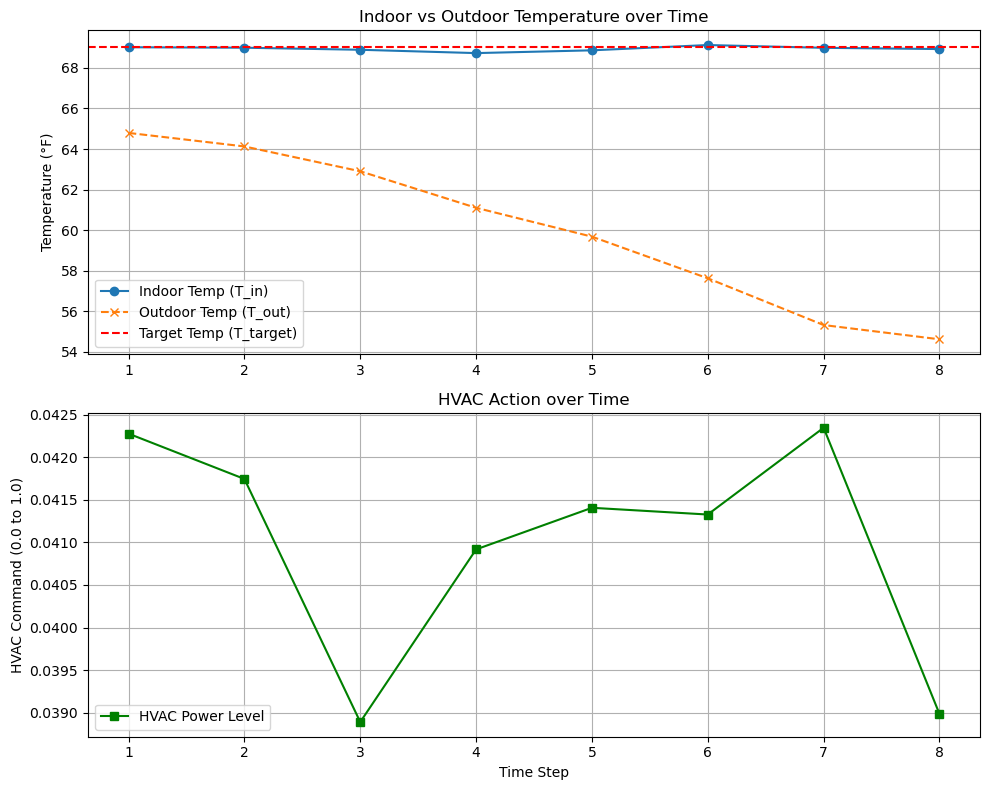

In [72]:
# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Indoor Temperature
axs[0].plot(time_steps, T_in_list, marker='o', label='Indoor Temp (T_in)')
axs[0].plot(time_steps, T_out_list, marker='x', linestyle='--', label='Outdoor Temp (T_out)')
axs[0].axhline(env.T_target, color='r', linestyle='--', label='Target Temp (T_target)')
axs[0].set_ylabel('Temperature (°F)')
axs[0].set_title('Indoor vs Outdoor Temperature over Time')
axs[0].legend()
axs[0].grid()

# Plot HVAC Actions
axs[1].plot(time_steps, action_list, marker='s', color='g', label='HVAC Power Level')
axs[1].set_ylabel('HVAC Command (0.0 to 1.0)')
axs[1].set_xlabel('Time Step')
axs[1].set_title('HVAC Action over Time')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


# traditional HVAC baseline

In [73]:
def traditional_hvac_baseline(env, threshold=1.0, hvac_power_on=1.0, episodes=10):
    total_energy = 0
    total_comfort_penalty = 0

    print("---- Traditional HVAC Baseline ----")
    for ep in range(episodes):
        obs, _ = env.reset()
        T_target = env.T_target
        episode_energy = 0
        episode_comfort = 0

        for step in range(env.episode_length):
            T_in, T_out, T_out_future, humid, wind_sp, time_step = obs

            # Rule-based control logic:
            if T_in > T_target + threshold:
                hvac_action = np.array([-hvac_power_on])  # Full cooling
            elif T_in < T_target - threshold:
                hvac_action = np.array([hvac_power_on])   # Full heating
            else:
                hvac_action = np.array([0.0])  # HVAC OFF

            obs, reward, done, _, _ = env.step(hvac_action)

            # Extract energy and comfort penalties for comparison
            energy_used = abs(hvac_action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            episode_energy += energy_used
            episode_comfort += comfort_penalty

            env.render()
            print(f"Action: {hvac_action[0]:.2f}, T_in: {env.T_in:.2f}°F, Energy: {energy_used:.2f}, Comfort Penalty: {comfort_penalty:.2f}")

            if done:
                break

        total_energy += episode_energy
        total_comfort_penalty += episode_comfort

        print(f"Episode {ep+1}: Energy = {episode_energy:.2f}, Comfort Penalty = {episode_comfort:.2f}")
        print("--------------------------------------------------")

    
    avg_energy = total_energy / episodes
    avg_comfort = total_comfort_penalty / episodes
    print("\n--- Traditional HVAC Summary ---")
    print(f"Avg Energy Used: {avg_energy:.2f}")
    print(f"Avg Comfort Penalty: {avg_comfort:.2f}")
    return avg_energy, avg_comfort


In [52]:
# After running traditional baseline
# Now run your RL agent on the same env for comparison

def evaluate_rl_agent(env, model, episodes=10): # num of times prediction is being done
    total_energy = 0
    total_comfort_penalty = 0

    print("---- RL Agent Evaluation ----")
    for ep in range(episodes):
        obs, _ = env.reset()
        T_target = env.T_target
        episode_energy = 0
        episode_comfort = 0

        for step in range(env.episode_length): # single prediction time steps 
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)

            energy_used = abs(action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            episode_energy += energy_used
            episode_comfort += comfort_penalty

            env.render()
            print(f"Action: {action[0]:.2f}, T_in: {env.T_in:.2f}°F, Energy: {energy_used:.2f}, Comfort Penalty: {comfort_penalty:.2f}")

            if done:
                break

        total_energy += episode_energy
        total_comfort_penalty += episode_comfort

        print(f"Episode {ep+1}: Energy = {episode_energy:.2f}, Comfort Penalty = {episode_comfort:.2f}")
        print("--------------------------------------------------")

    avg_energy = total_energy / episodes
    avg_comfort = total_comfort_penalty / episodes
    print("\n--- RL Agent Summary ---")
    print(f"Avg Energy Used: {avg_energy:.2f}")
    print(f"Avg Comfort Penalty: {avg_comfort:.2f}")
    return avg_energy, avg_comfort


---- Traditional HVAC Baseline ----
Step 1: T_in=66.69°F, T_out=35.4°F, Humid=90.0%, Wind=1.0 m/s
Action: 0.00, T_in: 66.69°F, Energy: 0.00, Comfort Penalty: 0.42
Step 2: T_in=66.11°F, T_out=35.8°F, Humid=86.0%, Wind=1.0 m/s
Action: 0.00, T_in: 66.11°F, Energy: 0.00, Comfort Penalty: 1.01
Step 3: T_in=71.06°F, T_out=38.4°F, Humid=93.0%, Wind=3.0 m/s
Action: 1.00, T_in: 71.06°F, Energy: 1.00, Comfort Penalty: 3.94
Step 4: T_in=65.50°F, T_out=39.2°F, Humid=93.0%, Wind=1.0 m/s
Action: -1.00, T_in: 65.50°F, Energy: 1.00, Comfort Penalty: 1.62
Step 5: T_in=70.25°F, T_out=41.4°F, Humid=81.0%, Wind=3.0 m/s
Action: 1.00, T_in: 70.25°F, Energy: 1.00, Comfort Penalty: 3.13
Step 6: T_in=64.12°F, T_out=43.4°F, Humid=70.0%, Wind=2.0 m/s
Action: -1.00, T_in: 64.12°F, Energy: 1.00, Comfort Penalty: 3.00
Step 7: T_in=67.56°F, T_out=44.5°F, Humid=81.0%, Wind=2.0 m/s
Action: 1.00, T_in: 67.56°F, Energy: 1.00, Comfort Penalty: 0.44
Step 8: T_in=67.38°F, T_out=46.0°F, Humid=81.0%, Wind=1.0 m/s
Action: 0.0

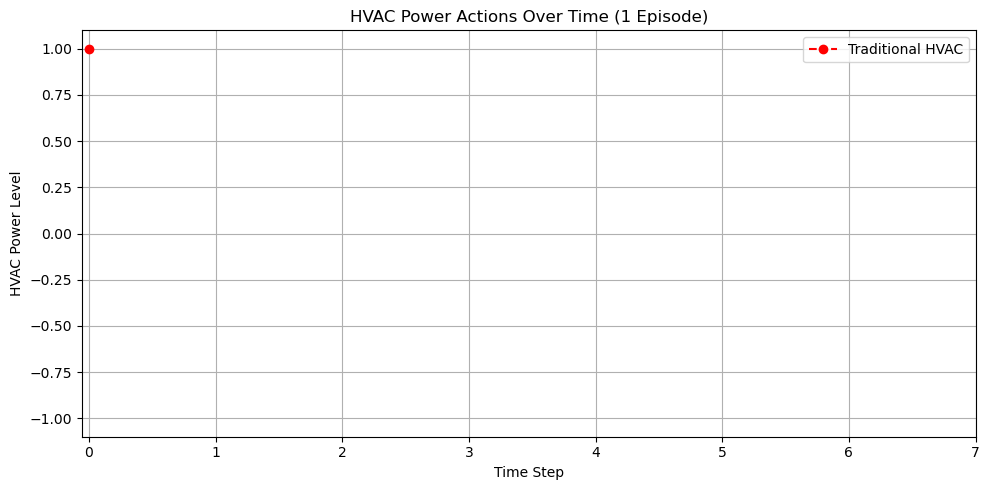


--- Traditional HVAC Summary ---
Avg Energy Used: 2.90
Avg Comfort Penalty: 10.48
---- RL Agent Evaluation ----
Step 1: T_in=67.60°F, T_out=50.4°F, Humid=87.0%, Wind=3.0 m/s
Action: 0.04, T_in: 67.60°F, Energy: 0.04, Comfort Penalty: 0.03
Step 2: T_in=67.64°F, T_out=49.3°F, Humid=81.0%, Wind=3.0 m/s
Action: 0.04, T_in: 67.64°F, Energy: 0.04, Comfort Penalty: 0.07
Step 3: T_in=67.38°F, T_out=48.3°F, Humid=87.0%, Wind=3.0 m/s
Action: 0.03, T_in: 67.38°F, Energy: 0.03, Comfort Penalty: 0.19
Step 4: T_in=67.03°F, T_out=47.0°F, Humid=87.0%, Wind=2.0 m/s
Action: 0.04, T_in: 67.03°F, Energy: 0.04, Comfort Penalty: 0.54
Step 5: T_in=66.98°F, T_out=45.8°F, Humid=87.0%, Wind=2.0 m/s
Action: 0.04, T_in: 66.98°F, Energy: 0.04, Comfort Penalty: 0.59
Step 6: T_in=66.83°F, T_out=44.6°F, Humid=93.0%, Wind=2.0 m/s
Action: 0.04, T_in: 66.83°F, Energy: 0.04, Comfort Penalty: 0.74
Step 7: T_in=67.00°F, T_out=44.3°F, Humid=87.0%, Wind=2.0 m/s
Action: 0.04, T_in: 67.00°F, Energy: 0.04, Comfort Penalty: 0.5

In [53]:
# Run both systems
avg_energy_baseline, avg_comfort_baseline = traditional_hvac_baseline(env, episodes=10)
avg_energy_rl, avg_comfort_rl = evaluate_rl_agent(env, model, episodes=10)

print("\n--- Final Comparison ---")
print(f"Traditional HVAC - Avg Energy: {avg_energy_baseline:.2f}, Avg Comfort: {avg_comfort_baseline:.2f}")
print(f"RL Agent        - Avg Energy: {avg_energy_rl:.2f}, Avg Comfort: {avg_comfort_rl:.2f}")


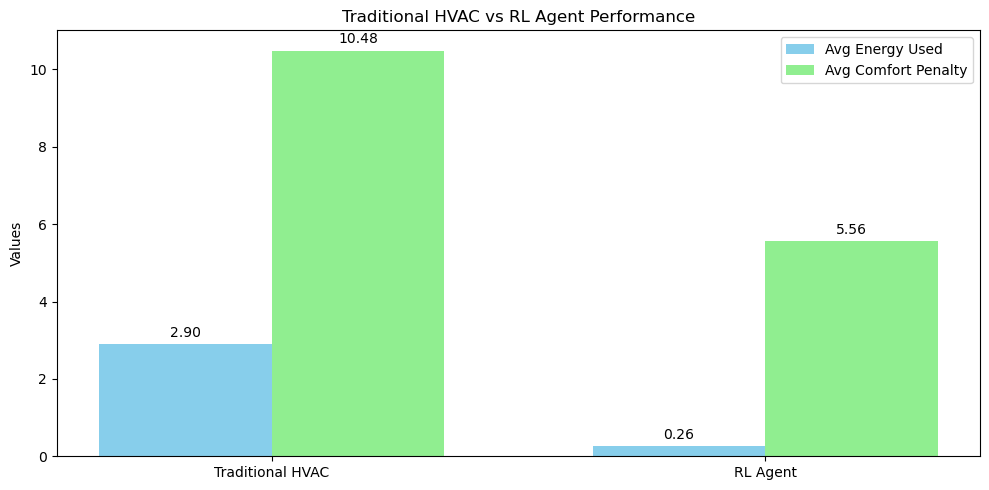

In [54]:
# Create data for plotting
labels = ['Traditional HVAC', 'RL Agent']
energy_values = [avg_energy_baseline, avg_energy_rl]
comfort_values = [avg_comfort_baseline, avg_comfort_rl]

x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(10, 5))

# Plot Energy Comparison
rects1 = ax.bar(x - width/2, energy_values, width, label='Avg Energy Used', color='skyblue')

# Plot Comfort Comparison
rects2 = ax.bar(x + width/2, comfort_values, width, label='Avg Comfort Penalty', color='lightgreen')

# Labels and formatting
ax.set_ylabel('Values')
ax.set_title('Traditional HVAC vs RL Agent Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach value labels to bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


### experiment do not touch

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def traditional_hvac_baseline_plot(env, threshold=1.0, hvac_power_on=1.0, episodes=10, plot_one_episode=True):
    total_energy = 0
    total_comfort_penalty = 0
    actions_to_plot = []  # Store actions for the first episode

    print("---- Traditional HVAC Baseline ----")
    for ep in range(episodes):
        obs, _ = env.reset()
        T_target = env.T_target
        episode_energy = 0
        episode_comfort = 0
        hvac_actions = []  # Store actions for this episode

        for step in range(env.episode_length):
            T_in, T_out, T_out_future, humid, wind_sp, time_step = obs

            # Rule-based control logic:
            if T_in > T_target + threshold:
                hvac_action = np.array([-hvac_power_on])  # Full cooling
            elif T_in < T_target - threshold:
                hvac_action = np.array([hvac_power_on])   # Full heating
            else:
                hvac_action = np.array([0.0])  # HVAC OFF

            hvac_actions.append(hvac_action[0])  # Store scalar for plotting

            obs, reward, done, _, _ = env.step(hvac_action)

            # Extract energy and comfort penalties for comparison
            energy_used = abs(hvac_action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            episode_energy += energy_used
            episode_comfort += comfort_penalty

            env.render()
            print(f"Action: {hvac_action[0]:.2f}, T_in: {env.T_in:.2f}°F, Energy: {energy_used:.2f}, Comfort Penalty: {comfort_penalty:.2f}")

            if done:
                break

        # Save actions for plotting if it's the first episode and plotting is enabled
        if plot_one_episode and ep == 0:
            actions_to_plot = hvac_actions

        total_energy += episode_energy
        total_comfort_penalty += episode_comfort

        print(f"Episode {ep+1}: Energy = {episode_energy:.2f}, Comfort Penalty = {episode_comfort:.2f}")
        print("--------------------------------------------------")

    # Plot actions from the first episode
    if plot_one_episode:
        plt.figure(figsize=(10, 5))
        plt.plot(actions_to_plot, label='Traditional HVAC Actions', marker='o', linestyle='--', color='red')
        plt.title('Traditional HVAC Power Actions Over Time (1st Episode)')
        plt.xlabel('Time Step')
        plt.ylabel('HVAC Power Level')
        plt.xticks(range(env.episode_length))
        plt.ylim(-1.1, 1.1)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_energy = total_energy / episodes
    avg_comfort = total_comfort_penalty / episodes
    print("\n--- Traditional HVAC Summary ---")
    print(f"Avg Energy Used: {avg_energy:.2f}")
    print(f"Avg Comfort Penalty: {avg_comfort:.2f}")
    return avg_energy, avg_comfort


---- Traditional HVAC Baseline ----
Step 1: T_in=68.41°F, T_out=41.3°F, Humid=93.0%, Wind=3.0 m/s
Action: 0.00, T_in: 68.41°F, Energy: 0.00, Comfort Penalty: 0.29
Step 2: T_in=68.05°F, T_out=41.3°F, Humid=93.0%, Wind=4.0 m/s
Action: 0.00, T_in: 68.05°F, Energy: 0.00, Comfort Penalty: 0.65
Step 3: T_in=67.92°F, T_out=41.4°F, Humid=93.0%, Wind=5.0 m/s
Action: 0.00, T_in: 67.92°F, Energy: 0.00, Comfort Penalty: 0.78
Step 4: T_in=67.97°F, T_out=42.0°F, Humid=87.0%, Wind=1.0 m/s
Action: 0.00, T_in: 67.97°F, Energy: 0.00, Comfort Penalty: 0.73
Step 5: T_in=67.59°F, T_out=43.1°F, Humid=87.0%, Wind=3.0 m/s
Action: 0.00, T_in: 67.59°F, Energy: 0.00, Comfort Penalty: 1.12
Step 6: T_in=72.93°F, T_out=44.0°F, Humid=93.0%, Wind=3.0 m/s
Action: 1.00, T_in: 72.93°F, Energy: 1.00, Comfort Penalty: 4.23
Step 7: T_in=66.96°F, T_out=45.1°F, Humid=87.0%, Wind=2.0 m/s
Action: -1.00, T_in: 66.96°F, Energy: 1.00, Comfort Penalty: 1.74
Step 8: T_in=72.13°F, T_out=47.1°F, Humid=87.0%, Wind=4.0 m/s
Action: 1.00

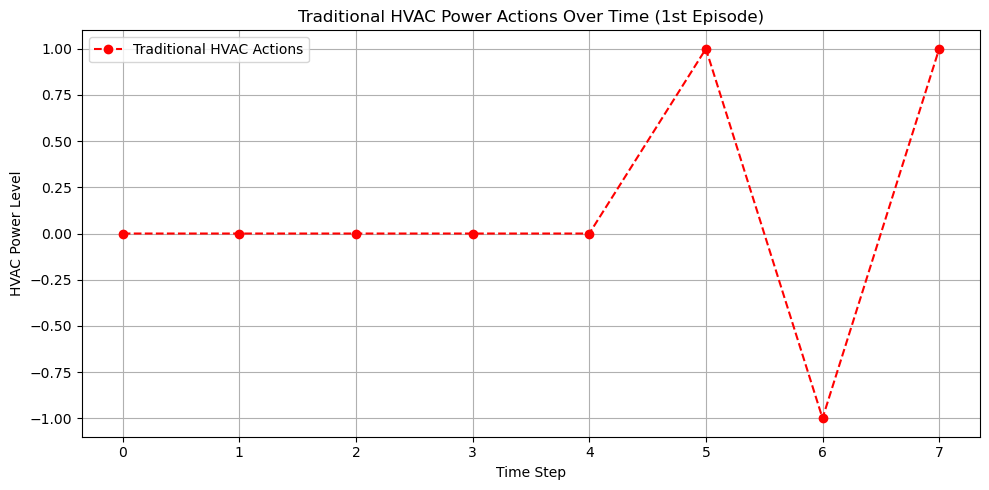


--- Traditional HVAC Summary ---
Avg Energy Used: 3.00
Avg Comfort Penalty: 12.97

Traditional HVAC Baseline Results over 10 episodes:
Average Energy Used: 3.00
Average Comfort Penalty: 12.97


In [75]:
# Assuming your environment 'env' is already created with your DataFrame

avg_energy, avg_comfort = traditional_hvac_baseline_plot(env, threshold=1.0, episodes=1)

print(f"\nTraditional HVAC Baseline Results over 10 episodes:")
print(f"Average Energy Used: {avg_energy:.2f}")
print(f"Average Comfort Penalty: {avg_comfort:.2f}")


In [95]:
def compare_traditional_vs_rl_no_custom_reset(env, model, episodes=5, threshold=1.0, hvac_power_on=1.0):
    traditional_results = []
    rl_results = []

    for ep in range(episodes):
        # Reset and run one real episode to capture weather data sequence
        obs, _ = env.reset()
        T_target = env.T_target
        episode_weather_data = []  # Store environment weather data per step
        T_in_initial = env.T_in

        # Step through the environment once to capture weather data
        for step in range(env.episode_length):
            T_out = env.df.loc[env.current_idx, 'temp']
            humid = env.df.loc[env.current_idx, 'humid']
            wind_sp = env.df.loc[env.current_idx, 'wind_sp']
            T_out_future = env.df.loc[env.current_idx + 8, 'temp']
            episode_weather_data.append((T_out, humid, wind_sp, T_out_future))

            # Advance step with no action (for data collection only)
            dummy_action = np.array([0.0])
            obs, _, done, _, _ = env.step(dummy_action)
            if done:
                break

        # -----------------------------------
        # Replay 1: Traditional HVAC on captured data
        # -----------------------------------
        env.reset()
        env.T_in = T_in_initial
        T_target = env.T_target
        traditional_energy = 0
        traditional_comfort = 0
        env.current_idx -= env.time_step  # Rewind the time index
        env.time_step = 0

        for step, (T_out, humid, wind_sp, T_out_future) in enumerate(episode_weather_data):
            if env.T_in > T_target + threshold:
                hvac_action = np.array([-hvac_power_on])
            elif env.T_in < T_target - threshold:
                hvac_action = np.array([hvac_power_on])
            else:
                hvac_action = np.array([0.0])

            # Apply the captured weather manually
            obs, reward, done, _, _ = env.step(hvac_action)

            energy_used = abs(hvac_action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            traditional_energy += energy_used
            traditional_comfort += comfort_penalty
            if done:
                break

        print(f"Episode {ep+1}: Traditional HVAC -> Energy: {traditional_energy:.2f}, Comfort: {traditional_comfort:.2f}")

        # -----------------------------------
        # Replay 2: RL Agent on same captured data
        # -----------------------------------
        env.reset()
        env.T_in = T_in_initial
        T_target = env.T_target
        rl_energy = 0
        rl_comfort = 0
        env.current_idx -= env.time_step  # Rewind again
        env.time_step = 0
        obs = env._get_obs()

        for step, (T_out, humid, wind_sp, T_out_future) in enumerate(episode_weather_data):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)

            energy_used = abs(action[0]) * env.energy_rate
            comfort_penalty = abs(env.T_in - T_target)

            rl_energy += energy_used
            rl_comfort += comfort_penalty
            if done:
                break

        print(f"Episode {ep+1}: RL Agent        -> Energy: {rl_energy:.2f}, Comfort: {rl_comfort:.2f}")
        print("--------------------------------------------------")

        traditional_results.append((traditional_energy, traditional_comfort))
        rl_results.append((rl_energy, rl_comfort))

    # Averages
    avg_trad_energy = np.mean([res[0] for res in traditional_results])
    avg_trad_comfort = np.mean([res[1] for res in traditional_results])
    avg_rl_energy = np.mean([res[0] for res in rl_results])
    avg_rl_comfort = np.mean([res[1] for res in rl_results])

    print("\n=== Final Comparison Summary ===")
    print(f"Traditional HVAC - Avg Energy: {avg_trad_energy:.2f}, Avg Comfort: {avg_trad_comfort:.2f}")
    print(f"RL Agent         - Avg Energy: {avg_rl_energy:.2f}, Avg Comfort: {avg_rl_comfort:.2f}")

    return {
        'traditional': {'avg_energy': avg_trad_energy, 'avg_comfort': avg_trad_comfort},
        'rl_agent': {'avg_energy': avg_rl_energy, 'avg_comfort': avg_rl_comfort},
        'per_episode': list(zip(traditional_results, rl_results))
    }


In [98]:
# Compare over 5 identical episodes
results = compare_traditional_vs_rl_no_custom_reset(env, model, episodes=1)

# Access results
print(results)


Episode 1: Traditional HVAC -> Energy: 3.00, Comfort: 12.87
Episode 1: RL Agent        -> Energy: 7.79, Comfort: 88.89
--------------------------------------------------

=== Final Comparison Summary ===
Traditional HVAC - Avg Energy: 3.00, Avg Comfort: 12.87
RL Agent         - Avg Energy: 7.79, Avg Comfort: 88.89
{'traditional': {'avg_energy': 3.0, 'avg_comfort': 12.873575613488498}, 'rl_agent': {'avg_energy': 7.794607400894165, 'avg_comfort': 88.88743497808305}, 'per_episode': [((3.0, 12.873575613488498), (7.794607400894165, 88.88743497808305))]}
